In [1]:
import time
import numpy as np

from gru_model import G_model
import torch
from torch import optim
from util import bce_loss, accuracy_function
from Paras import Para

from data_loader import fin_train_loader, fin_validation_loader, fin_test_loader

Para.dataset_len = len(fin_train_loader)
Para.log_step = len(fin_train_loader) // 4


optimizer = torch.optim.RMSprop(G_model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

def train(model, epoch, versatile=True):
    start_time = time.time()
    model = model.train()
    train_loss = 0.
    accuracy = 0.
    batch_num = len(fin_train_loader)
    _index = 0

    for _index, data in enumerate(fin_train_loader):
        spec_input, target = data['mel'], data['tag']

        if Para.cuda:
            spec_input = spec_input.cuda()
            target = target.cuda()

        optimizer.zero_grad()
        predicted = model(spec_input)

        loss_value = bce_loss(predicted, target)
        accuracy_value = accuracy_function(predicted, target)

        loss_value.backward()
        optimizer.step()

        train_loss += loss_value.data.item()
        accuracy += accuracy_value

        if versatile:
            if (_index + 1) % Para.log_step == 0:
                elapsed = time.time() - start_time
                print('Epoch{:3d} | {:3d}/{:3d} batches | {:5.2f}ms/ batch | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
                      .format(epoch, _index + 1, batch_num,
                              elapsed * 1000 / (_index + 1),
                              train_loss / (_index + 1),
                              accuracy * 100 / (_index + 1)))

    train_loss /= (_index + 1)
    accuracy /= (_index + 1)

    print('-' * 99)
    print('End of training epoch {:3d} | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
          .format(epoch, (time.time() - start_time),
                  train_loss, accuracy * 100))

    return train_loss, accuracy


def validate_test(model, epoch, test=False):
    start_time = time.time()
    model = model.eval()
    v_loss = 0.
    accuracy = 0.
    data_loader_use = fin_validation_loader if not test else fin_test_loader
    _index = 0
    for _index, data in enumerate(data_loader_use):
        spec_input, target = data['mel'], data['tag']

        if Para.cuda:
            spec_input = spec_input.cuda()
            target = target.cuda()

        with torch.no_grad():

            predicted = model(spec_input)

            loss_value = bce_loss(predicted, target)
            accuracy_value = accuracy_function(predicted, target)

            v_loss += loss_value.data.item()
            accuracy += accuracy_value

    v_loss /= (_index + 1)
    accuracy /= (_index + 1)

    if not test:
        print('End of validation epoch {:3d} | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
              .format(epoch, (time.time() - start_time),
                v_loss, accuracy * 100))
    else:
        print('End of Test | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
              .format((time.time() - start_time),
                v_loss, accuracy * 100))
    print('-' * 99)

    return v_loss, accuracy

# Train the model here

In [2]:
Para.epoch_num = 60

In [3]:
t_loss, t_accu, v_loss, v_accu = [], [], [], []
decay_cnt = 0

for epoch in range(1, Para.epoch_num + 1):
    if Para.cuda:
        G_model.cuda()

    train_loss, train_accuracy = train(G_model, epoch)
    validation_loss, validation_accuracy = validate_test(G_model, epoch, test=False)

    t_loss.append(train_loss)
    t_accu.append(train_accuracy)

    v_loss.append(validation_loss)
    v_accu.append(validation_accuracy)

    # use accuracy to find the best model
    if np.max(t_accu) == t_accu[-1]:
        print('***Found Best Training Model***')
    if np.max(v_accu) == v_accu[-1]:
        with open(Para.MODEL_SAVE_PATH_2A, 'wb') as f:
            torch.save(G_model.cpu().state_dict(), f)
            print('***Best Validation Model Found and Saved***')

    print('-' * 99)

    # Use BCE loss value for learning rate scheduling
    decay_cnt += 1

    if np.min(t_loss) not in t_loss[-3:] and decay_cnt > 2:
        scheduler.step()
        decay_cnt = 0
        print('***Learning rate decreased***')
        print('-' * 99)

Epoch  1 | 154/619 batches | 33.42ms/ batch | BCE: 0.3207 | Accuracy: 16.48% |
Epoch  1 | 308/619 batches | 32.61ms/ batch | BCE: 0.3168 | Accuracy: 20.07% |
Epoch  1 | 462/619 batches | 32.77ms/ batch | BCE: 0.3131 | Accuracy: 22.29% |
Epoch  1 | 616/619 batches | 32.88ms/ batch | BCE: 0.3097 | Accuracy: 23.62% |
---------------------------------------------------------------------------------------------------
End of training epoch   1 | time: 20.37s | BCE: 0.3095 | Accuracy: 23.67% |
End of validation epoch   1 | time:  0.90s | BCE: 0.2850 | Accuracy: 34.65% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch  2 | 154/619 batches | 32.55ms/ batch | BCE: 0.2921 | Accuracy: 30.52% |
Epoch  2 | 308/619 batches | 33.03ms/ batch | BCE: 0.2905 | Accuracy: 30.58

Epoch 11 | 154/619 batches | 41.94ms/ batch | BCE: 0.1729 | Accuracy: 62.70% |
Epoch 11 | 308/619 batches | 41.79ms/ batch | BCE: 0.1748 | Accuracy: 62.68% |
Epoch 11 | 462/619 batches | 41.74ms/ batch | BCE: 0.1742 | Accuracy: 63.07% |
Epoch 11 | 616/619 batches | 41.71ms/ batch | BCE: 0.1728 | Accuracy: 63.51% |
---------------------------------------------------------------------------------------------------
End of training epoch  11 | time: 25.84s | BCE: 0.1732 | Accuracy: 63.45% |
End of validation epoch  11 | time:  1.17s | BCE: 0.1479 | Accuracy: 69.38% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch 12 | 154/619 batches | 39.78ms/ batch | BCE: 0.1632 | Accuracy: 65.02% |
Epoch 12 | 308/619 batches | 40.68ms/ batch | BCE: 0.1670 | Accuracy: 64.08

Epoch 21 | 154/619 batches | 41.94ms/ batch | BCE: 0.1138 | Accuracy: 76.95% |
Epoch 21 | 308/619 batches | 41.77ms/ batch | BCE: 0.1133 | Accuracy: 77.11% |
Epoch 21 | 462/619 batches | 41.69ms/ batch | BCE: 0.1123 | Accuracy: 77.22% |
Epoch 21 | 616/619 batches | 41.68ms/ batch | BCE: 0.1123 | Accuracy: 77.20% |
---------------------------------------------------------------------------------------------------
End of training epoch  21 | time: 25.81s | BCE: 0.1124 | Accuracy: 77.20% |
End of validation epoch  21 | time:  1.20s | BCE: 0.1063 | Accuracy: 78.35% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
---------------------------------------------------------------------------------------------------
Epoch 22 | 154/619 batches | 39.66ms/ batch | BCE: 0.1083 | Accuracy: 78.49% |
Epoch 22 | 308/619 batches | 40.63ms/ batch | BCE: 0.1106 | Accuracy: 78.02% |
Epoch 22 | 462/619 batches | 40.94ms/ ba

Epoch 31 | 154/619 batches | 17.43ms/ batch | BCE: 0.0769 | Accuracy: 85.47% |
Epoch 31 | 308/619 batches | 17.27ms/ batch | BCE: 0.0769 | Accuracy: 85.45% |
Epoch 31 | 462/619 batches | 17.19ms/ batch | BCE: 0.0768 | Accuracy: 85.34% |
Epoch 31 | 616/619 batches | 17.15ms/ batch | BCE: 0.0770 | Accuracy: 85.28% |
---------------------------------------------------------------------------------------------------
End of training epoch  31 | time: 10.64s | BCE: 0.0769 | Accuracy: 85.33% |
End of validation epoch  31 | time:  0.59s | BCE: 0.0921 | Accuracy: 81.96% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch 32 | 154/619 batches | 17.40ms/ batch | BCE: 0.0725 | Accuracy: 85.67% |
Epoch 32 | 308/619 batches | 17.26ms/ batch | BCE: 0.0722 | Accuracy: 85.31

Epoch 41 | 154/619 batches | 41.86ms/ batch | BCE: 0.0505 | Accuracy: 90.46% |
Epoch 41 | 308/619 batches | 41.68ms/ batch | BCE: 0.0538 | Accuracy: 90.08% |
Epoch 41 | 462/619 batches | 41.65ms/ batch | BCE: 0.0525 | Accuracy: 90.38% |
Epoch 41 | 616/619 batches | 41.62ms/ batch | BCE: 0.0518 | Accuracy: 90.62% |
---------------------------------------------------------------------------------------------------
End of training epoch  41 | time: 25.78s | BCE: 0.0518 | Accuracy: 90.65% |
End of validation epoch  41 | time:  1.09s | BCE: 0.0871 | Accuracy: 83.38% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
---------------------------------------------------------------------------------------------------
Epoch 42 | 154/619 batches | 24.77ms/ batch | BCE: 0.0489 | Accuracy: 91.11% |
Epoch 42 | 308/619 batches | 33.20ms/ batch | BCE: 0.0489 | Accuracy: 91.03% |
Epoch 42 | 462/619 batches | 36.02ms/ ba

Epoch 51 | 462/619 batches | 55.50ms/ batch | BCE: 0.0345 | Accuracy: 93.55% |
Epoch 51 | 616/619 batches | 56.28ms/ batch | BCE: 0.0349 | Accuracy: 93.58% |
---------------------------------------------------------------------------------------------------
End of training epoch  51 | time: 34.85s | BCE: 0.0349 | Accuracy: 93.59% |
End of validation epoch  51 | time:  1.55s | BCE: 0.0951 | Accuracy: 84.02% |
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
Epoch 52 | 154/619 batches | 59.32ms/ batch | BCE: 0.0313 | Accuracy: 94.07% |
Epoch 52 | 308/619 batches | 58.93ms/ batch | BCE: 0.0325 | Accuracy: 93.85% |
Epoch 52 | 462/619 batches | 54.35ms/ batch | BCE: 0.0325 | Accuracy: 94.07% |
Epoch 52 | 616/619 batches | 55.52ms/ batch | BCE: 0.0327 | Accuracy: 94.08% |
------------------------------------------------------------------------

In [4]:
import matplotlib.pyplot as plt

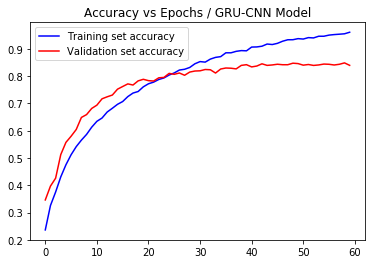

In [5]:
plt.figure()
plt.plot(t_accu, c='b', label='Training set accuracy')
plt.plot(v_accu, c='r', label='Validation set accuracy')
plt.title('Accuracy vs Epochs / GRU-CNN Model')
plt.legend()
plt.show()

In [6]:
G_model.load_state_dict(torch.load(Para.MODEL_SAVE_PATH_2A))
validate_test(G_model, 0, test=True)

End of Test | time:  0.95s | BCE: 0.1035 | Accuracy: 84.13% |
---------------------------------------------------------------------------------------------------


(0.10351452380657578, 0.8413461538461539)

In [7]:
store_dict = dict()
store_dict['train_a'] = t_accu
store_dict['train_l'] = t_loss
store_dict['valid_a'] = v_accu
store_dict['valid_l'] = v_loss

In [8]:
import json
with open('train_on_old_CRNN.json', 'w+') as f:
    json.dump(store_dict, f)